In [1]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import clear_output

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
import time
import warnings

from KittiLabel import KittiLabel

%matplotlib inline

In [2]:
# DIR PATHS

MODEL_PATH = "models_dwld/ssd_resnet50_v1_fpn_1024x1024_coco17_tpu-8"
PIPELINE_CONFIG_PATH = MODEL_PATH + "/pipeline.config"
CHECKPOINT_PATH = MODEL_PATH + "/checkpoint/ckpt-0"

TRAIN_IMAGE_DIR = "train_size_1024_1024_padded_seed_20"
VAL_IMAGE_DIR = "val_size_1024_1024_padded_seed_20"
TEST_IMAGE_DIR = "test_size_1024_1024_padded_seed_20"

IMAGE_DIMS = (1024, 1024)

In [3]:
# IMG TO NP

def load_image_into_numpy_array(path):
    #img_data = tf.io.gfile.GFile(path, 'rb').read()
    #image = Image.open(BytesIO(img_data))
    #(im_width, im_height) = image.size
    #return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)
    loaded_img = load_img(path)
    img_array = img_to_array(loaded_img)
    img_array_int8 = img_array.astype(np.uint8)
    return img_array_int8

In [4]:
# RESCALE BB

def rescale_bounding_box(bbox):
    xmin, ymin, xmax, ymax = bbox
    return [ymin / IMAGE_DIMS[1], xmin / IMAGE_DIMS[0], ymax / IMAGE_DIMS[1], xmax / IMAGE_DIMS[0]]

In [5]:
# PLOT RESULTS

def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

# TRAIN

In [6]:
num_classes = 2

In [7]:
tf.keras.backend.clear_session()

print('Building model and restoring weights for fine-tuning... ', end="", flush=True)

# LOAD CONFIG
configs = config_util.get_configs_from_pipeline_file(PIPELINE_CONFIG_PATH)

# CHANGE CONFIG
model_config = configs["model"]
model_config.ssd.num_classes = num_classes
model_config.ssd.freeze_batchnorm = True

# BUILD THE MODEL
detection_model = model_builder.build(
    model_config=model_config, 
    is_training=True
)

# SETUP CKPT RESTORE
fake_box_predictor = tf.compat.v2.train.Checkpoint(
    _base_tower_layers_for_heads=detection_model._box_predictor._base_tower_layers_for_heads,
    # _prediction_heads=detection_model._box_predictor._prediction_heads,
    #    (i.e., the classification head that we *will not* restore)
    _box_prediction_head=detection_model._box_predictor._box_prediction_head,
)
fake_model = tf.compat.v2.train.Checkpoint(
    _feature_extractor=detection_model._feature_extractor,
    _box_predictor=fake_box_predictor
)
ckpt = tf.compat.v2.train.Checkpoint(model=fake_model)
ckpt.restore(CHECKPOINT_PATH).expect_partial()

# RUN THROUGH DUMMY IMAGE
image, shapes = detection_model.preprocess(tf.zeros([1, 1024, 1024, 3]))
prediction_dict = detection_model.predict(image, shapes)
_ = detection_model.postprocess(prediction_dict, shapes)
print('Weights restored!')

Building model and restoring weights for fine-tuning... Weights restored!


In [8]:
tf.keras.backend.set_learning_phase(True)

C:\Users\Roko\anaconda3\envs\tensorflow\lib\site-packages\keras\backend.py:451: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


In [9]:
# SELECT VARIABLES IN TOP LAYERS TO FINE TUNE
trainable_variables = detection_model.trainable_variables
to_fine_tune = []
prefixes_to_train = [
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalBoxHead',
  'WeightSharedConvolutionalBoxPredictor/WeightSharedConvolutionalClassHead'
]
for var in trainable_variables:
  if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
    to_fine_tune.append(var)

In [10]:
def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
    @tf.function
    def train_step_fn(image_tensors,
                      groundtruth_boxes_list,
                      groundtruth_classes_list):
        shapes = tf.constant(batch_size * [[1024, 1024, 3]], dtype=tf.int32)
        model.provide_groundtruth(
            groundtruth_boxes_list=groundtruth_boxes_list,
            groundtruth_classes_list=groundtruth_classes_list
        )
        with tf.GradientTape() as tape:
            preprocessed_images = tf.concat(
                [detection_model.preprocess(image_tensor)[0] for image_tensor in image_tensors], axis=0
            )
            prediction_dict = model.predict(preprocessed_images, shapes)
            losses_dict = model.loss(prediction_dict, shapes)
            total_loss = losses_dict['Loss/localization_loss'] + losses_dict['Loss/classification_loss']
            gradients = tape.gradient(total_loss, vars_to_fine_tune)
            optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
        return total_loss
    return train_step_fn

In [11]:
learning_rate = 0.001

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
#optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
train_step_fn = get_model_train_step_function(
    detection_model, optimizer, to_fine_tune
)

# load image files

In [12]:
train_image_files = [
    f for f in os.listdir(TRAIN_IMAGE_DIR) if os.path.isfile(os.path.join(TRAIN_IMAGE_DIR, f)) and 
    os.path.join(TRAIN_IMAGE_DIR, f).endswith(".png")
]
val_image_files = [
    f for f in os.listdir(VAL_IMAGE_DIR) if os.path.isfile(os.path.join(VAL_IMAGE_DIR, f)) and 
    os.path.join(VAL_IMAGE_DIR, f).endswith(".png")
]
test_image_files = [
    f for f in os.listdir(TEST_IMAGE_DIR) if os.path.isfile(os.path.join(TEST_IMAGE_DIR, f)) and 
    os.path.join(TEST_IMAGE_DIR, f).endswith(".png")
]

In [13]:
num_epochs = 1
batch_size = 2
num_batches = int(np.ceil(len(train_image_files) / batch_size))

In [14]:
# one-hot-encode classes

# class 1: Car + Van + Truck
# class 2: Pedestrian + Person_sitting + Cyclist

class_label_to_index = {
    "Car": 1,
    "Van": 1,
    "Truck": 1,
    "Pedestrian": 2,
    "Person_sitting": 2,
    "Cyclist": 2
}

ohe_class = {
    1: [1, 0],
    2: [0, 1]
}

category_index = {
    1: {
        "id": 1,
        "name": "vehicle"
    },
    2: {
        "id": 2,
        "name": "vru"
    }
}

In [15]:
warnings.filterwarnings('ignore')
# train
start_time = time.time()

for i in range(1, num_epochs + 1):
    current_batch = 0
    while current_batch * batch_size < len(train_image_files):
        # get current batch files and labels
        current_batch_files = train_image_files[current_batch * batch_size:(current_batch + 1) * batch_size]
        current_batch_labels = [
            file_name.replace(".png", ".txt") for file_name in current_batch_files
        ]
        
        # initialize ground truth lists
        batch_classes_gt = []
        batch_boxes_gt = []
        
        # split labels into classes_gt and boxes_gt
        for current_batch_label in current_batch_labels:
            classes_gt = []
            boxes_gt = []
            with open(os.path.join(TRAIN_IMAGE_DIR, current_batch_label)) as label_file:
                for label_line in label_file:
                    # load kitti label
                    loaded_kitti_label = KittiLabel(label_line.strip())
                    
                    # append to ground truth if class of interest
                    if loaded_kitti_label.class_label in class_label_to_index.keys():
                        classes_gt.append(ohe_class[class_label_to_index[loaded_kitti_label.class_label]])
                        boxes_gt.append(rescale_bounding_box(loaded_kitti_label.bbox))
            batch_classes_gt.append(tf.constant(classes_gt, dtype=tf.float32))
            batch_boxes_gt.append(tf.constant(boxes_gt, dtype=tf.float32))
        
        # get image tensors
        batch_image_tensors = []
        for current_batch_file in current_batch_files:
            image_np = load_image_into_numpy_array(os.path.join(TRAIN_IMAGE_DIR, current_batch_file))
            batch_image_tensors.append(tf.expand_dims(tf.convert_to_tensor(image_np, dtype=tf.float32), axis=0))
            
        # execute train step
        total_loss = train_step_fn(
            batch_image_tensors,
            batch_boxes_gt,
            batch_classes_gt
        )
        
        # print progress
        clear_output(wait=True)
        print(f"Done with epoch {i} batch {current_batch+1}/{num_batches}")
        current_batch += 1
        if current_batch == 500:
            break
    
end_time = time.time()
print(f"Took {end_time - start_time:.2f} seconds")

Done with epoch 1 batch 500/2618
Took 909.69 seconds


# TEST

In [16]:
example_test_image = load_image_into_numpy_array("test_size_1024_1024_padded_seed_20/000201.png")
examples = []
examples.append(np.expand_dims(example_test_image, axis=0))

In [17]:
@tf.function
def detect(input_tensor):
    preprocessed_image, shapes = detection_model.preprocess(input_tensor)
    prediction_dict = detection_model.predict(preprocessed_image, shapes)
    return detection_model.postprocess(prediction_dict, shapes)

In [22]:
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.6
    )
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

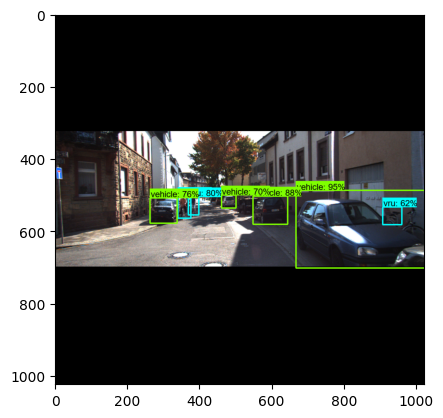

In [23]:
for i in range(1):
    exa = tf.convert_to_tensor(examples[i], dtype=tf.float32)
    detections = detect(exa)
    plot_detections(
        examples[i][0],
        detections["detection_boxes"][0].numpy(),
        detections["detection_classes"][0].numpy().astype(np.uint32) + 1,
        detections["detection_scores"][0].numpy(),
        category_index,
        figsize=(30, 30),
        #image_name="test_example1.jpg"
    )